# Resnet50+FPN+SSD

自己从头到尾手写的第一个模型，在华为云的ModelArts上测试一下效果：

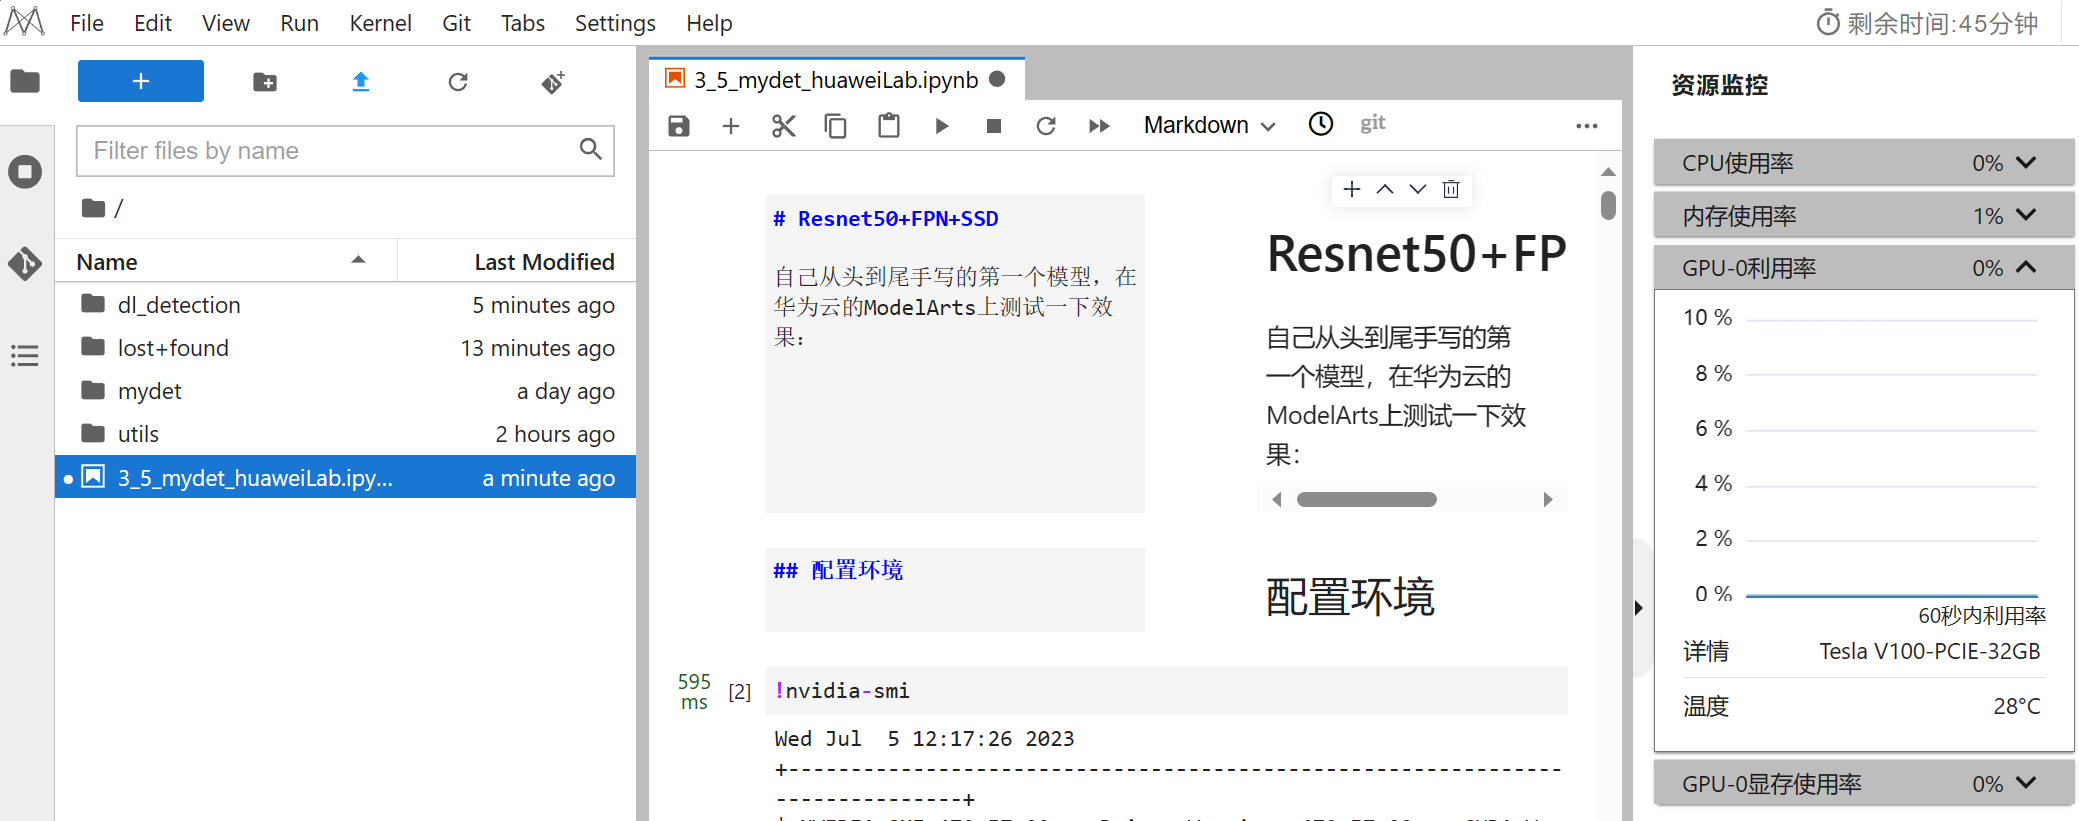


## 查看GPU环境

In [1]:
!nvidia-smi

Wed Jul  5 17:13:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:00:0D.0 Off |                    0 |
| N/A   40C    P0    41W / 250W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

> 华为云可以很轻松的创建notebook后从OBS服务获取上传的数据

In [2]:
!pip install -r requirements.txt

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-1.8/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# !pip uninstall numpy -y

In [4]:
# !pip install numpy

## 加载数据

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


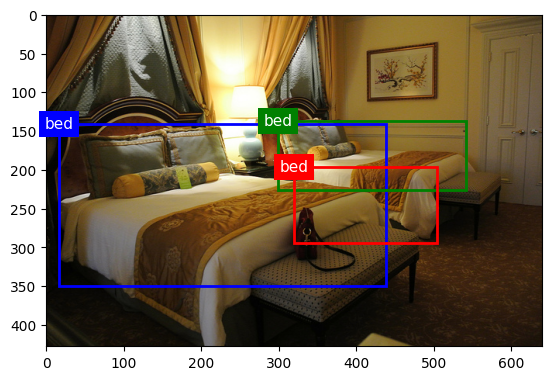

In [5]:
from utils.data import read_Cocodata_train, show_sample
Cocodata_train = read_Cocodata_train(is_transform = False)
show_sample(Cocodata_train, 0)

In [6]:
Cocodata_train = read_Cocodata_train(is_transform = True)

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


In [7]:
Cocodata_train[0][0].shape, Cocodata_train[0][1].shape

(torch.Size([3, 256, 256]), torch.Size([50, 5]))

## 定义模型

In [8]:
from mydet.backbone import Backbone
from mydet.neck import Neck
from mydet.head import Head
import torch

class R50_FPN_SSD(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = Backbone(model='resnet50')
        self.neck = Neck()
        self.head = Head()

    def forward(self, X):
        backbone_out = self.backbone(X)
        neck_out = self.neck(backbone_out)
        head_out = self.head(neck_out) # anchor, cls, offset
        return head_out

## 设定训练参数

In [9]:
Cocodata_train

Dataset CocoDetection
    Number of datapoints: 33354
    Root location: ./dl_detection/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               Resize(size=(256, 256), interpolation=bilinear)
           )
Target transform: <function target_transform at 0x7fef07cc1dd0>

In [10]:
# 将数据集取一小部分出来，用于训练
# Cocodata_train_small = torch.utils.data.Subset(Cocodata_train, range(0, 1000))

## 开始训练

In [11]:
from utils.device import try_gpu
from mydet.bbox.assigner import BBoxAssigner
device = try_gpu()
# net = R50_FPN_SSD()
net = torch.load('resnet50_fpn_ssd_huawei.pth',map_location=device) # 加载上一次训练好的数据继续训练
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001) # first 0.001 -> 0.0001
num_epochs  = 5
batch_size = 128
iou_threshold = 0.5

In [12]:
# 为锚框分配真实边界框
bbox_assigner = BBoxAssigner(
    device = device,
    iou_threshold = iou_threshold
)

In [13]:
train_dataloader = torch.utils.data.DataLoader(
    Cocodata_train,
    batch_size = batch_size,
    shuffle = True
)

### 训练函数

In [14]:
from utils.tools import Timer, Accumulator
from mydet.loss import calc_loss
from mydet.eval import cls_eval, bbox_eval

def train(net, train_dataloader, optimizer, num_epochs, device):
    net = net.to(device)
    timer = Timer()
    timer_per_batch = Timer()
    for epoch in range(num_epochs):
        # 训练精确度的和，训练精确度的和中的示例数
        # 绝对误差的和，绝对误差的和中的示例数
        metric = Accumulator(5)
        net.train()
        for features, target in train_dataloader:
            timer.start()
            timer_per_batch.start()
            optimizer.zero_grad()
            X, Y = features.to(device), target.to(device)

            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)

            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = bbox_assigner.multibox_target(anchors, Y)

            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels,
                        bbox_preds, bbox_labels,
                        bbox_masks)

            l.mean().backward() # 这里是默认对第一个维度做平均，即对batchsize做平均

            optimizer.step()

            metric.add(
                cls_eval(cls_preds, cls_labels),
                cls_labels.numel(),
                bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                bbox_labels.numel(),
                X.shape[0]
            )

            # 打印一下metric中的内容
            print(f"{epoch + 1:3d} epochs, {metric[4]:.1f} examples,"
                    f"{metric[0] / metric[1]:.2e} class acc,"
                    f"{metric[2] / metric[3]:.2e} bbox mae,"
                    f"{ X.shape[0] / timer_per_batch.stop():.1f} examples/sec on {str(device)}")

        cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]

        print(f"{epoch + 1:2d}/{num_epochs:2d} epoch, \
            class error = {cls_err}, bbox mae = {bbox_mae}")

    print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
    print(f'{len(train_dataloader.dataset) / timer.stop():.1f} examples/sec on '
        f'{str(device)}')

### 开始训练

In [15]:
train(
    net = net,
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    num_epochs = num_epochs,
    device = device
)

  1 epochs, 128.0 examples,9.89e-01 class acc,1.32e-01 bbox mae,71.1 examples/sec on cuda:0
  1 epochs, 256.0 examples,6.48e-01 class acc,1.54e-01 bbox mae,72.7 examples/sec on cuda:0
  1 epochs, 384.0 examples,7.61e-01 class acc,1.38e-01 bbox mae,72.9 examples/sec on cuda:0
  1 epochs, 512.0 examples,8.18e-01 class acc,1.48e-01 bbox mae,72.2 examples/sec on cuda:0
  1 epochs, 640.0 examples,8.52e-01 class acc,1.71e-01 bbox mae,72.4 examples/sec on cuda:0
  1 epochs, 768.0 examples,8.75e-01 class acc,1.87e-01 bbox mae,71.7 examples/sec on cuda:0
  1 epochs, 896.0 examples,8.90e-01 class acc,2.09e-01 bbox mae,72.0 examples/sec on cuda:0
  1 epochs, 1024.0 examples,9.01e-01 class acc,2.19e-01 bbox mae,71.9 examples/sec on cuda:0
  1 epochs, 1152.0 examples,9.09e-01 class acc,2.31e-01 bbox mae,72.4 examples/sec on cuda:0
  1 epochs, 1280.0 examples,9.15e-01 class acc,2.38e-01 bbox mae,72.2 examples/sec on cuda:0
  1 epochs, 1408.0 examples,9.20e-01 class acc,2.47e-01 bbox mae,72.4 example

In [21]:
# 将学习率手动调小十倍继续训练
optimizer.param_groups[0]['lr'] *= 0.1

In [22]:
train(
    net = net,
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    num_epochs = num_epochs,
    device = device
)

  1 epochs, 128.0 examples,9.86e-01 class acc,2.34e-02 bbox mae,71.8 examples/sec on cuda:0
  1 epochs, 256.0 examples,9.87e-01 class acc,2.25e-02 bbox mae,72.1 examples/sec on cuda:0
  1 epochs, 384.0 examples,9.87e-01 class acc,2.24e-02 bbox mae,71.6 examples/sec on cuda:0
  1 epochs, 512.0 examples,9.87e-01 class acc,2.20e-02 bbox mae,72.3 examples/sec on cuda:0
  1 epochs, 640.0 examples,9.87e-01 class acc,2.17e-02 bbox mae,72.7 examples/sec on cuda:0
  1 epochs, 768.0 examples,9.87e-01 class acc,2.17e-02 bbox mae,72.2 examples/sec on cuda:0
  1 epochs, 896.0 examples,9.87e-01 class acc,2.16e-02 bbox mae,72.2 examples/sec on cuda:0
  1 epochs, 1024.0 examples,9.87e-01 class acc,2.16e-02 bbox mae,72.8 examples/sec on cuda:0
  1 epochs, 1152.0 examples,9.87e-01 class acc,2.18e-02 bbox mae,72.5 examples/sec on cuda:0
  1 epochs, 1280.0 examples,9.87e-01 class acc,2.16e-02 bbox mae,71.8 examples/sec on cuda:0
  1 epochs, 1408.0 examples,9.87e-01 class acc,2.15e-02 bbox mae,72.2 example

In [18]:
torch.save(net,'resnet50_fpn_ssd_huawei3.pth')

In [19]:
net2 = torch.load('resnet50_fpn_ssd_huawei3.pth',map_location=device)

In [20]:
# 保存到华为云的OBS的桶中
import moxing as mox
mox.file.copy('resnet50_fpn_ssd_huawei.pth', 'obs://dl-detection-data/resnet50_fpn_ssd_huawei3.pth')

INFO:root:Using MoXing-v2.1.0.5d9c87c8-5d9c87c8
INFO:root:Using OBS-Python-SDK-3.20.9.1
